# Goal
We want $$0 = \dot{\hat{\rho}} = \mathcal{L}\hat{\rho} = -i\left[\hat H, \hat \rho\right]+\sum_j \frac{\gamma_j}{2}\left[2\hat L_j\hat\rho\hat L_j^\dagger - \left\{\hat L_j^\dagger\hat L_j, \hat\rho\right\}\right]$$

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '16'
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

Pauli Matrices

In [2]:
sigma_x = np.array([[0, 1], [1, 0]], dtype = 'complex128')
sigma_y = np.array([[0, -1j], [1j, 0]], dtype = 'complex128')
sigma_z = np.array([[1, 0], [0, -1]], dtype = 'complex128')
identity = np.array([[1, 0], [0, 1]], dtype = 'complex128')

Some parameters

In [3]:
num_latt = 4
coup_stren = 2


$$ H = \frac{V}{4}\sum_{\langle j, l\rangle}\hat\sigma_j^z\hat\sigma_l^z+\frac{g}{2}\sum_j\hat\sigma_j^x$$
where $\hat\sigma_j^\alpha$ means the Pauli matrix acting on the $j$-th site.
$$ \hat L_j^{(z)} = \hat\sigma_j^- = \frac{1}{2}\left(\hat\sigma_j^x-i\hat\sigma_j^y\right)$$

In [4]:
# make tensor product of two matrices (copied over from povm code, 
# but I didn't reverse the order because later I shall use this function
# in a different order.)
def tensorproduct(matrix1, matrix2):
    dim = matrix1.shape[0] * matrix2.shape[0]
    # didn't reverse the order here
    return np.tensordot(matrix1, matrix2, axes = 0).swapaxes(1, 2).reshape(dim, dim)

In [5]:
# generate hamiltonion
def gen_H(num, V, g):
    hamiltonion = np.zeros((2**num, 2**num), dtype = 'complex128')
    for i in range(num):
        term1 = np.ones((1, 1), dtype = 'complex128')
        term2 = np.ones((1, 1), dtype = 'complex128')
        for j in range(num): 
            if j == i or j == i + 1 or (i == num - 1 and j == 0): # wallpaper(cyclic) bondary condition
                term1 = tensorproduct(term1, sigma_z) # order here not the same as in POVM
                #print(i, j)
                #print(term1)
            else:
                term1 = tensorproduct(term1, identity) # order here not the same as in POVM
            if j == i:
                term2 = tensorproduct(term2, sigma_x) # order here not the same as in POVM
            else:
                term2 = tensorproduct(term2, identity) # order here not the same as in POVM
        term1 = term1 * V / 4
        #print(term1)
        term2 = term2 * g / 2
        hamiltonion += term1 + term2
    return hamiltonion
                

In [6]:
# generate L_j
def gen_L_j(num, i):
    term = np.ones((1, 1), dtype = 'complex128')
    for j in range(num):
        if j == i:
            term = tensorproduct(term, (sigma_x - 1j * sigma_y) / 2)
        else:
            term = tensorproduct(term, identity)
    return term
            

In [7]:
# remember to test the functions above

In [8]:
def curly_L(rho, V, g): # input should be a matrix of 2**num_latt * 2**num_latt and I ignored the gamma and assume it's the unit
    h = gen_H(num_latt, V, g)
    rho = rho.reshape((2**num_latt, 2**num_latt))
    #print(rho.shape, h.shape)
    #print(rho.dtype, h.dtype)
    term1 = -1j * (h @ rho - rho @ h)
    term2 = np.zeros((2**num_latt, 2**num_latt), dtype = 'complex128')
    for i in range(num_latt):
        Li = np.matrix(gen_L_j(num_latt, i))
        term2 += (2 * Li@rho@Li.H - Li.H@Li@ rho - rho@Li.H@Li) / 2
    return (term1 + term2)
    

In [9]:
def gen_rho(parameters):
    matrix = np.array(np.append(parameters, 0))
    length = int(round(np.sqrt(matrix.size)))
    matrix = matrix.reshape(length, length)
    # extract upper trangle (excluding diagonal)
    upper = np.triu(matrix, k=1)
    # extract lower trangle (excluding diagonal)
    lower = np.tril(matrix, k=-1)
    # extract diagonal
    diagnal = np.diag(matrix)
    # sum of diagonal (trace) should be 1
    diagnal.flags.writeable = True # otherwise is read only, not sure why
    diagnal[-1] = 1 - np.sum(diagnal[:-1])
    # take the upper triangle and diagonal as the real part of the matrix
    real = upper + upper.T + np.diag(diagnal)
    # take the lower tirangle as the imaginary part of the matrix
    imaginary = 1j * lower - 1j * lower.T
    return real + imaginary
    

In [10]:
gen_rho(np.random.random(4**2 -1))

array([[ 0.48569635+0.j        ,  0.65686707-0.85432042j,
         0.82054826-0.13702442j,  0.96360595-0.85272703j],
       [ 0.65686707+0.85432042j,  0.16294598+0.j        ,
         0.28824907-0.47794105j,  0.04017701-0.20784223j],
       [ 0.82054826+0.13702442j,  0.28824907+0.47794105j,
         0.76462457+0.j        ,  0.4241541 -0.87706751j],
       [ 0.96360595+0.85272703j,  0.04017701+0.20784223j,
         0.4241541 +0.87706751j, -0.4132669 +0.j        ]])

In [11]:
def gen_rho_dot(parameters, V, g):
    rho = gen_rho(parameters)
    rho_dot = curly_L(rho, V, g)
    return rho_dot

In [12]:
def loss(parameters, V, g):
    rho_dot = gen_rho_dot(parameters, V, g)
    #print(0)
    return np.linalg.norm(rho_dot)

In [13]:
def train(parameters,V,g, max_iter=10, step_rate=0.1):
        
    step = [0]
    def callback(x, *args, **kwargs):
        step[0] += 1
        print('step = %d, loss = %s'%(step[0], loss(x, V, g)))
        
    parameters = np.array(parameters)
    from scipy.optimize import minimize
    res = minimize(loss, x0=parameters, args = (V, g), \
                       method='L-BFGS-B', jac = '2-point', tol=1e-10, \
                       options={'maxiter': max_iter, 'disp': 0, 'gtol':1e-10, 'ftol':0}, \
                       callback=callback)
    return res.fun, res.x

In [14]:
g_list = np.linspace(1, 4, 7)
optimized_parameters_list = []
loss_list = []
for g in g_list:
    initial_parameters = np.random.random(4**num_latt - 1)
    #loss, optimized_parameters = train(initial_parameters, 2, g)
    res = optimize.minimize(loss, initial_parameters, args = (coup_stren, g))
    optimized_parameters = res.x
    loss_value = res.fun
    optimized_parameters_list.append(optimized_parameters)
    loss_list.append(loss_value)
    print(g)
rho_list = list(map(gen_rho, optimized_parameters_list))
#rho_list = optimized_rho_list
print(loss_list)

1.0
1.5
2.0
2.5
3.0
3.5
4.0
[1.1196429842386485e-06, 1.95383703103847e-06, 3.163440900120234e-06, 3.880315086469517e-06, 4.751266933737654e-06, 5.664717032866804e-06, 6.882723454553808e-06]


In [15]:
optimized_parameters_list

[array([ 1.63121358e-03,  2.95595365e-05,  2.95425618e-05, -1.90300613e-03,
         2.95792021e-05, -1.15877238e-03, -1.90301831e-03, -6.34664929e-03,
         2.95540786e-05, -1.90301443e-03, -1.15877286e-03, -6.34665195e-03,
        -1.90299857e-03, -6.34664252e-03, -6.34664748e-03, -2.89885040e-02,
         1.63117455e-03,  3.13714996e-03,  1.61841797e-03,  2.95011192e-03,
         1.59250388e-03,  9.18185706e-04,  2.78473372e-03,  1.78392054e-03,
         1.61842601e-03,  2.95013614e-03,  1.10320106e-03,  2.08195435e-03,
         2.78476387e-03,  1.78395077e-03,  3.35210915e-03,  1.06859449e-03,
         1.63117593e-03, -6.75037966e-09,  3.13716383e-03,  2.95012045e-03,
         1.61841927e-03,  1.10316658e-03,  2.95014946e-03,  2.08194663e-03,
         1.59249408e-03,  2.78475615e-03,  9.18180172e-04,  1.78391087e-03,
         2.78475068e-03,  3.35211437e-03,  1.78392095e-03,  1.06857261e-03,
         2.74862642e-03,  3.42891524e-03,  3.42894577e-03,  1.14047071e-02,
         2.7

In [16]:
rho_list

[array([[ 1.63121358e-03+0.00000000e+00j,  2.95595365e-05-1.63117455e-03j,
          2.95425618e-05-1.63117593e-03j, -1.90300613e-03-2.74862642e-03j,
          2.95792021e-05-1.63117545e-03j, -1.15877238e-03-1.23442566e-03j,
         -1.90301831e-03-2.74862901e-03j, -6.34664929e-03-3.51368514e-03j,
          2.95540786e-05-1.63117515e-03j, -1.90301443e-03-2.74863302e-03j,
         -1.15877286e-03-1.23443574e-03j, -6.34665195e-03-3.51369829e-03j,
         -1.90299857e-03-2.74865203e-03j, -6.34664252e-03-3.51369058e-03j,
         -6.34664748e-03-3.51370509e-03j, -2.89885040e-02-7.41521846e-03j],
        [ 2.95595365e-05+1.63117455e-03j,  3.13714996e-03+0.00000000e+00j,
          1.61841797e-03+6.75037966e-09j,  2.95011192e-03-3.42891524e-03j,
          1.59250388e-03-5.82206013e-09j,  9.18185706e-04-2.55350450e-03j,
          2.78473372e-03-1.92761337e-03j,  1.78392054e-03-9.13391789e-03j,
          1.61842601e-03+1.12262398e-08j,  2.95013614e-03-3.42894367e-03j,
          1.10320106e-03

In [17]:
def gen_big_sigma(sigma, num):
    big_sigma = np.zeros((2**num, 2**num), dtype = 'complex128')
    for i in range(num):
        current_sigma = np.array([1])
        for j in range(num):
            if j == i:
                current_sigma = tensorproduct(current_sigma, sigma)
            else:
                current_sigma = tensorproduct(current_sigma, identity)
            #print(i, j, current_sigma)
        big_sigma += current_sigma
    big_sigma /= num
    return big_sigma

In [18]:
big_sigma_x = gen_big_sigma(sigma_x, num_latt)
big_sigma_y = gen_big_sigma(sigma_y, num_latt)
big_sigma_z = gen_big_sigma(sigma_z, num_latt)

In [19]:
big_sigma_z

array([[ 1. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0.5+0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
       

In [20]:
sigma_x_expect = list(map(np.trace, list(map(lambda r: r @ big_sigma_x, rho_list))))
sigma_y_expect = list(map(np.trace, list(map(lambda r: r @ big_sigma_y, rho_list))))
sigma_z_expect = list(map(np.trace, list(map(lambda r: r @ big_sigma_z, rho_list))))
sigma_x_expect_old = list(map(np.trace, rho_list @ big_sigma_x))
sigma_y_expect_old = list(map(np.trace, rho_list @ big_sigma_y))
sigma_z_expect_old = list(map(np.trace, rho_list @ big_sigma_z))

In [21]:
sigma_x_expect

[(0.4397803303465766+0j),
 (0.4117011839736181+0j),
 (0.24507631701114432+6.938893903907228e-18j),
 (0.13570560220834005+0j),
 (0.07942493292945842+6.938893903907228e-18j),
 (0.049726755597040984+0j),
 (0.032996494001163335+0j)]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


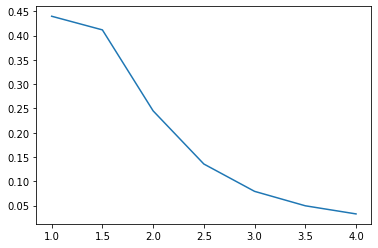

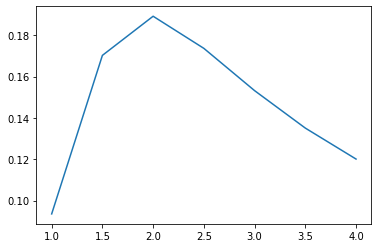

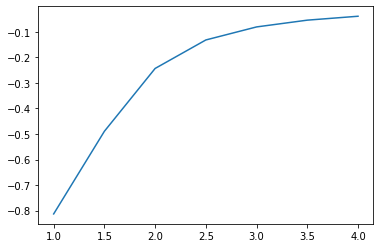

In [22]:
plt.figure()
plt.plot(g_list, sigma_x_expect)
plt.show()
plt.figure()
plt.plot(g_list, sigma_y_expect)
plt.show()
plt.figure()
plt.plot(g_list, sigma_z_expect)
plt.show()

In [23]:
initial_parameters = np.random.random(4 ** num_latt - 1)
gen_rho_dot(initial_parameters, 2, 1)

array([[-1.12566897e+00+0.j        , -2.70295169e-01-0.50632837j,
        -9.94537003e-01+3.08242686j, -1.15134028e+00+1.41980203j,
        -3.67707243e+00+1.39090646j, -4.86421790e+00+1.02160797j,
        -2.68264531e+00+1.81084869j,  1.79040559e-01-0.464317j  ,
        -4.19482641e+00+0.40882361j, -2.69941437e+00+0.66563121j,
        -3.07873570e+00+2.4188456j , -1.21850790e+00+0.81605639j,
        -2.05879237e+00+2.25900895j, -3.03942213e+00-0.11939708j,
        -4.40543955e-01-0.72093884j, -5.08957376e-01+1.31097286j],
       [-2.70295169e-01+0.50632837j,  3.06743228e-01+0.j        ,
        -1.08001743e+00+2.00417584j, -5.27907544e-01-0.22097835j,
        -7.97670357e-01+0.07847191j, -1.07194262e+00-0.84350222j,
        -1.68794569e+00+1.55262984j,  1.01759661e+00+0.58474055j,
        -1.73025625e+00+2.10411068j, -7.77055125e-01-0.12423116j,
        -3.18335302e+00-0.89536822j, -1.31283014e+00+0.21958785j,
        -7.32492372e-01+0.98320005j, -8.75173702e-01+0.66270476j,
         

In [24]:
somelist = [np.array([[1,2,3],[4,5,6],[7,8,9]]), np.array([[1,2,3],[4,5,6],[7,8,9]]) * 2]

In [25]:
somelist @ np.array([[1,2,3],[4,5,6],[7,8,9]])

array([[[ 30,  36,  42],
        [ 66,  81,  96],
        [102, 126, 150]],

       [[ 60,  72,  84],
        [132, 162, 192],
        [204, 252, 300]]])